In [1]:
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import math

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)


In [2]:
################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)
        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)
        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(2, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        # x = F.pad(x, [0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2

        # x = x[..., :-self.padding] # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x = shape[0], shape[1]
        gridx = torch.tensor(np.linspace(0, 2*math.pi, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1).repeat([batchsize, 1, 1])
        return gridx.to(device)

In [3]:
################################################################
#  configurations
################################################################
ntrain = 10000
ntest = 625

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = h

batch_size = 10
learning_rate = 0.001

epochs = 10
step_size = 50
gamma = 0.5

modes = 16
width = 64


################################################################
# read data
################################################################

# Data is of the shape (number of samples, grid size)
dataloader = MatReader('data/possion_data3.1_10000_8192.mat')
x_train = dataloader.read_field('f_train')[:ntrain,::sub]
y_train = dataloader.read_field('u_train')[:ntrain,::sub]
x_test=dataloader.read_field('f_test')[:ntest,::sub]
y_test=dataloader.read_field('u_test')[:ntest,::sub]

x_train = x_train.reshape(ntrain,-1,1)
x_test = x_test.reshape(ntest,-1,1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

# model
model = FNO1d(modes, width).cuda()
print('number of params:', count_params(model))


number of params: 414337


0 13.8750558 1079.2333270480633 0.26648738119602206 0.8376398124694824
1 11.009066299999997 15.184095720767974 0.11136796206235886 0.8788473098754883
2 11.0326351 12.386445019841194 0.09941985280513764 0.8980051055908204
3 11.205798399999999 9.958705067396163 0.08817610317766666 0.9155488754272461
4 12.062301399999996 9.366112647891045 0.0852941657602787 0.9269314315795898
5 11.89733249999999 8.966406163096428 0.08270766705274582 0.9355008544921875
6 12.829624800000005 8.232062180638314 0.07863550084531307 0.9361041458129883
7 12.442506900000012 7.687027539372444 0.07562193675339222 0.9318513305664062
8 12.02533720000001 7.351559543848038 0.07346878750622272 0.9441689987182618
9 12.343735699999996 7.300999104142189 0.07205143529772759 0.9449312118530273
617


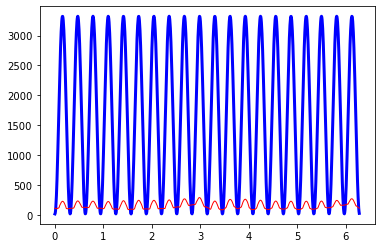

In [4]:
################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    #animator = Animator(xlabel='epoch', xlim=[1, epochs], ylim=[0, 0.1], legend=['train_l2'])
    t1 = default_timer()
    # train_mse = 0
    # train_l2 = 0
    metric_train = Accumulator(3) #累加每epoch，训练集上的mseloss,训练集上的l2_loss,测试集上的l2_loss
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss
        optimizer.step()

        metric_train.add(mse.item(), l2.item(), 0)
        # train_mse += mse.item()
        # train_l2 += l2.item()

    scheduler.step()
    model.eval()
    # test_l2 = 0.0
    
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            metric_train.add(0, 0, test_l2)

    train_mse = metric_train[0] / len(train_loader)
    train_l2 = metric_train[1] / ntrain
    test_l2 = metric_train[2] / ntest

    t2 = default_timer()
    #animator.add(ep , (train_l2))
    print(ep, t2-t1, train_mse, train_l2, test_l2)
    

# torch.save(model.state_dict(), 'model/params_possion_data3.1_10000_1024')

# pred = torch.zeros(y_test.shape)
# index = 0
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
# with torch.no_grad():
#     for x, y in test_loader:
#         test_l2 = 0
#         x, y = x.cuda(), y.cuda()
#
#         out = model(x).view(-1)
#         pred[index] = out
#
#         test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
#         if index % 10 == 0:
#             print(index, test_l2)
#         index = index + 1

# scipy.io.savemat('pred/burger_test.mat', mdict={'pred': pred.cpu().numpy()})



7244


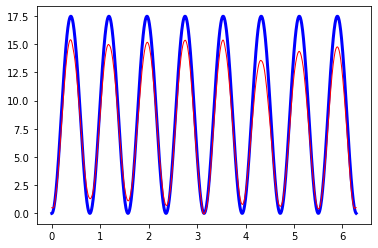

In [10]:
num=random.randint(1,ntrain)
print(num)
x_random=x_train[num,:,:].reshape(1,-1,1)
y_random=y_train[num,:]
y_pre=model(x_random.cuda())
plt.plot(np.linspace(0,2*math.pi,len(y_random)), y_random, color="blue", linewidth=3.0, linestyle="-", label="-")
plt.plot(np.linspace(0,2*math.pi,len(y_random)), y_pre.view(-1).to(torch.device("cpu")).detach().numpy(), color="red", linewidth=1.0, linestyle="solid", label="--")
plt.show()